In [21]:
import argparse, os, sys
import json
from pathlib import Path
import pandas as pd
import logging

from TraceLens import TreePerfAnalyzer, JaxTreePerfAnalyzer, DataLoader

In [23]:
profile_path = '/home/guangphu/perf-profiling/data/llm_traces/mi355x/hunyuan_t129/plugins/profile/2025_06_25_12_43_37/chi-mi300x-007.ord.vultr.cpe.ice.amd.com.xplane.pb'

In [25]:
data = DataLoader.load_data(profile_path, save_preprocessed=True)

I0000 00:00:1761051608.354092   45273 xplane_to_tools_data.cc:376] serving tool: trace_viewer@ with options: {}
I0000 00:00:1761051621.611622   45273 trace_events.cc:389] Loaded 1982601 events after filtering 0 events from LevelDb fast file: /home/guangphu/perf-profiling/data/llm_traces/mi355x/hunyuan_t129/plugins/profile/2025_06_25_12_43_37/chi-mi300x-007.ord.vultr.cpe.ice.amd.com.SSTABLE
I0000 00:00:1761051621.719881   45273 trace_events.cc:398] Added 1982601 visible events from LevelDb fast file: /home/guangphu/perf-profiling/data/llm_traces/mi355x/hunyuan_t129/plugins/profile/2025_06_25_12_43_37/chi-mi300x-007.ord.vultr.cpe.ice.amd.com.SSTABLE
I0000 00:00:1761051623.982530   45273 trace_events_to_json.h:80] Generated JSON events: complete: 1982601 complete+flow: 0 counter: 0 async: 0


In [6]:
perf_analyzer = JaxTreePerfAnalyzer.from_file(profile_path)

2025-10-20 15:31:18.214969: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-20 15:31:18.246389: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-20 15:31:18.518694: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-20 15:31:18.716830: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760974278.860978   45273 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760974278.90

Building tree with add_python_func=False
Building CPU op tree with add_python_func=False


In [16]:
op_events = [
                event
                for event in perf_analyzer.tree.events
                if event.get("gpu_kernel_op_cat", "None").lower() == 'te'
            ]
len(op_events)

18648

In [17]:
df_ops = perf_analyzer.build_df_perf_metrics(op_events)
df_ops.shape

(18648, 26)

In [18]:
df_ops["perf model"].value_counts()

perf model
jax_te_fused_attn        10944
jax_te_fused_attn_bwd     7704
Name: count, dtype: int64

In [19]:
df_op_perf_model = df_ops[
            df_ops["perf model"].str.contains('jax_te')
        ]
df_op_perf_model.shape

(18648, 26)

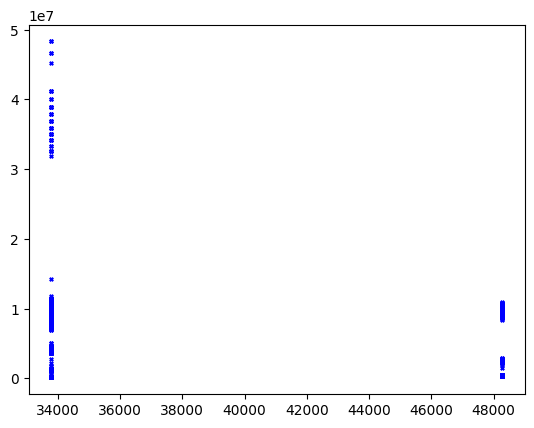

In [20]:
import matplotlib.pyplot as plt

x_realized_intensity = list(df_op_perf_model["FLOPS/Byte"])
y_realized_performance = list(df_op_perf_model["TFLOPS/s"])
plt.scatter(
        x_realized_intensity,
        y_realized_performance,
        marker="x",
        s=6,
        color="blue",
        label="Performance data",
    )